# Sequence-to-Sequence Abstracter: Card Sorting

## Set Up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import sklearn.metrics
from sklearn.model_selection import train_test_split
import pydealer

import seq2seq_transformer
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder

from hand2hand import Cards
import utils

2023-01-29 21:04:34.248758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%env "WANDB_NOTEBOOK_NAME" "autoregressive_abstracter_hand_sorting.ipynb"

import wandb
wandb.login()

env: "WANDB_NOTEBOOK_NAME"="autoregressive_abstracter_hand_sorting.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


True

In [3]:
def create_callbacks(monitor='loss'):
    callbacks = [
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbMetricsLogger(log_freq='epoch'),
        # wandb.keras.WandbModelCheckpoint(filepath='models/model_{epoch:02d}', monitor=monitor, mode='auto', save_freq='epoch')
#         wandb.keras.WandbCallback(
#             monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
#             training_data=train_ds, validation_data=val_ds,
#             labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

# metrics = [
#         tf.keras.metrics.BinaryAccuracy(name='acc'),
#         tf.keras.metrics.Precision(class_id=1, name='precision'),
#         tf.keras.metrics.Recall(class_id=1, name='recall'),
#         tf.keras.metrics.AUC(curve='ROC', multi_label=True, name='auc')
#         ]

# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# opt = tf.keras.optimizers.Adam()

## Dataset

In [4]:
hand_size = 7

deck = Cards()
pydeck = pydealer.Deck()
pydeck.shuffle()

In [5]:
n = 10000
BEGIN_HAND = 52 # token for 'beginning of hand'
END_HAND = 53 # token for 'end of hand'

hands = np.array(n*(hand_size+2)*[0]).reshape(n, hand_size+2)
hands_sorted = np.array(n*(hand_size+2)*[0]).reshape(n, hand_size+2)

for i in np.arange(n):
    hand = pydeck.deal(hand_size)
    if len(hand) < hand_size:
        #print('shuffling deck')
        pydeck = pydealer.Deck()
        pydeck.shuffle()
        hand = pydeck.deal(hand_size)
    source = list(deck.index_pyhand(hand))
    source.insert(0,BEGIN_HAND)
    source.append(END_HAND)
    hands[i] = np.array(source)
    deck.sort_pyhand(hand)
    target = list(deck.index_pyhand(hand))
    target.insert(0,BEGIN_HAND)
    target.append(END_HAND)
    hands_sorted[i] = np.array(target)


In [6]:
hands_train, hands_test, sorted_train, sorted_test = train_test_split(hands, hands_sorted, test_size=0.25)

source_train = hands_train
target_train = sorted_train[:,:-1]
labels_train = sorted_train[:,1:]

source_test = hands_test
target_test = sorted_test[:,:-1]
labels_test = sorted_test[:,1:]

In [7]:
def evaluate_seq2seq_model(model):
    n = len(source_test)
    output = np.zeros(n*(hand_size+2), dtype=int).reshape(n,hand_size+2)
    output[:,0] = BEGIN_HAND
    for i in range(hand_size+1):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    acc = (np.sum(output[:,1:] == labels_test))/np.prod(labels_test.shape)
    print('per-card accuracy: %.2f%%' % (100*acc))

    return acc

## Standard Transformer

In [8]:
# from seq2seq_transformer import Encoder

# inputs = layers.Input(shape=(9,), name='token_input')
# target = layers.Input(shape=(8,), name='token_target')

# token_embedder = layers.Embedding(54, 128, name='vector_embedding')
# pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
# pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')
# encoder = Encoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='transformer_encoder')

# decoder = Decoder(num_layers=3, num_heads=2, dff=64, dropout_rate=0.1, name='transformer_decoder')

# x = token_embedder(inputs)
# x = pos_embedding_adder_input(x)

# encoder_context = encoder(x)

# target_embedding = token_embedder(target)
# target_embedding = pos_embedding_adder_target(target_embedding)

# x = decoder(target_embedding, encoder_context)

# x = layers.Dense(54)(x)

# transformer = Model(inputs=[inputs, target], outputs=x)

In [9]:
from seq2seq_transformer import Encoder, AddPositionalEmbedding

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='transformer'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=encoder_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [10]:
transformer = Transformer(num_layers=2, num_heads=2, dff=64, 
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

2023-01-29 21:05:38.730910: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vast/palmer/apps/avx.grace/software/Code-Server/4.7.0/lib:/gpfs/loomis/apps/avx/software/Perl/5.32.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/DB/18.1.40-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libreadline/8.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/gettext/0.21-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/ncurses/6.2-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/XZ/5.2.5-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/expat/2.2.9-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/cURL/7.72.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/zlib/1.2.11-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/GCCcore/10.2.0/lib64:/gpfs/loomis/a

In [11]:
from seq2seq_transformer import masked_loss, masked_accuracy

transformer.compile(loss=masked_loss, optimizer=tf.keras.optimizers.Adam(), metrics=masked_accuracy)
transformer((source_train, target_train))

transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 decoder (ContextDecoder)    multiple                  562560    
                                                       

In [12]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='std transformer')
history = transformer.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 16s 47ms/step - loss: 1.6652 - masked_accuracy: 0.5645
Epoch 2/20
118/118 [==============================] - 5s 41ms/step - loss: 0.1498 - masked_accuracy: 0.9610
Epoch 3/20
118/118 [==============================] - 5s 41ms/step - loss: 0.0662 - masked_accuracy: 0.9829
Epoch 4/20
118/118 [==============================] - 5s 40ms/step - loss: 0.0372 - masked_accuracy: 0.9907
Epoch 5/20
118/118 [==============================] - 5s 39ms/step - loss: 0.0300 - masked_accuracy: 0.9923
Epoch 6/20
118/118 [==============================] - 5s 39ms/step - loss: 0.0275 - masked_accuracy: 0.9928
Epoch 7/20
118/118 [==============================] - 4s 38ms/step - loss: 0.0216 - masked_accuracy: 0.9941
Epoch 8/20
118/118 [==============================] - 5s 39ms/step - loss: 0.0299 - masked_accuracy: 0.9921
Epoch 9/20
118/118 [==============================] - 4s 37ms/step - loss: 0.0174 - masked_accuracy: 0.9953
Epoch 10/20
118/118 [======

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▇██████████████████
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.01541
epoch/masked_accuracy,0.99613


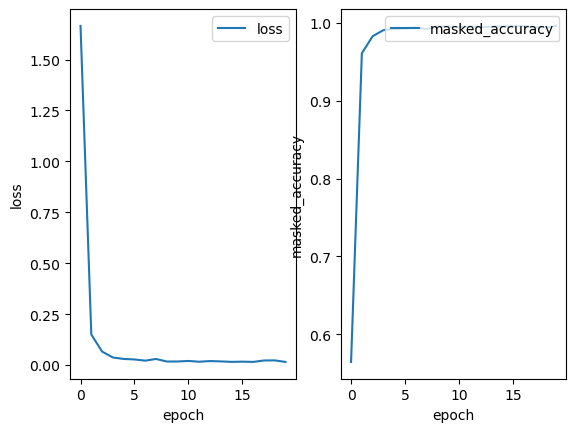

In [13]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [14]:
evaluate_seq2seq_model(transformer);

per-card accuracy: 95.18%


## Seq2Seq Abstracter with 'Symbolic' Cross-Attention $(Q=A, K=E, V=A)$

In [18]:
from symbolic_decoder import SymbolicDecoder

class Seq2SeqSymbolicAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='seq2seq_symbolic_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = SymbolicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=abstracted_context, value_seq=abstracted_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [19]:
seq2seq_symbolic_abstracter = Seq2SeqSymbolicAbstracter(num_layers=2, num_heads=2, dff=64,
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

In [20]:
from seq2seq_transformer import masked_loss, masked_accuracy

seq2seq_symbolic_abstracter.compile(loss=masked_loss, optimizer=tf.keras.optimizers.Adam(), metrics=masked_accuracy)
seq2seq_symbolic_abstracter((source_train, target_train))

seq2seq_symbolic_abstracter.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (SymbolicDecoder  multiple                 563712    
 )                                                     

In [21]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive symbolic abstracter')
history = seq2seq_symbolic_abstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 24s 66ms/step - loss: 2.6943 - masked_accuracy: 0.2064
Epoch 2/20
118/118 [==============================] - 7s 63ms/step - loss: 2.3924 - masked_accuracy: 0.2360
Epoch 3/20
118/118 [==============================] - 7s 63ms/step - loss: 2.2371 - masked_accuracy: 0.2696
Epoch 4/20
118/118 [==============================] - 7s 63ms/step - loss: 2.0643 - masked_accuracy: 0.3181
Epoch 5/20
118/118 [==============================] - 8s 65ms/step - loss: 1.9218 - masked_accuracy: 0.3576
Epoch 6/20
118/118 [==============================] - 7s 63ms/step - loss: 1.7479 - masked_accuracy: 0.4100
Epoch 7/20
118/118 [==============================] - 8s 64ms/step - loss: 1.5649 - masked_accuracy: 0.4623
Epoch 8/20
118/118 [==============================] - 8s 64ms/step - loss: 1.4011 - masked_accuracy: 0.5117
Epoch 9/20
118/118 [==============================] - 7s 63ms/step - loss: 1.2337 - masked_accuracy: 0.5729
Epoch 10/20
118/118 [======

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁
epoch/masked_accuracy,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇███
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.43544
epoch/masked_accuracy,0.85946


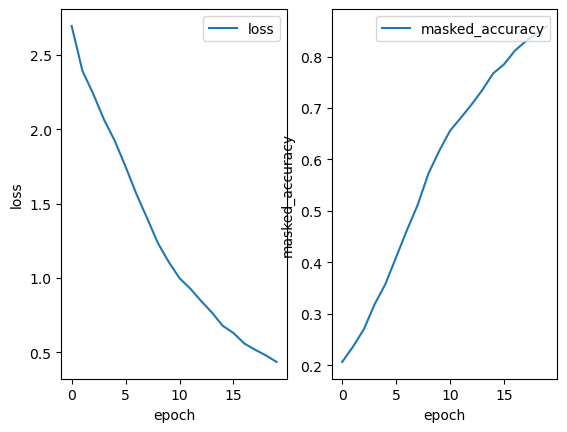

In [22]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [23]:
evaluate_seq2seq_model(seq2seq_symbolic_abstracter);

per-card accuracy: 84.14%


## Seq2Seq Abstracter with 'Episodic' Cross-Attention $(Q=E, K=E, V=A)$

In [24]:
from seq2seq_transformer import EpisodicDecoder

class Seq2SeqEpisodicAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='seq2seq_episodic_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = EpisodicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=abstracted_context, value_seq=abstracted_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [25]:
seq2seq_episodic_abstracter = Seq2SeqEpisodicAbstracter(num_layers=2, num_heads=2, dff=64, 
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

In [26]:
from seq2seq_transformer import masked_loss, masked_accuracy, CustomSchedule

learning_rate = CustomSchedule(d_model=128)
seq2seq_episodic_abstracter.compile(
    loss=masked_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=masked_accuracy)
seq2seq_episodic_abstracter((source_train, target_train))

seq2seq_episodic_abstracter.summary()

Model: "autoregressive_episodic_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (EpisodicDecoder  multiple                 563712    
 )                              

In [27]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive relational abstracter')
history = seq2seq_episodic_abstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 23s 67ms/step - loss: 4.2453 - masked_accuracy: 0.0724
Epoch 2/20
118/118 [==============================] - 7s 59ms/step - loss: 3.4109 - masked_accuracy: 0.1602
Epoch 3/20
118/118 [==============================] - 7s 59ms/step - loss: 2.8975 - masked_accuracy: 0.1915
Epoch 4/20
118/118 [==============================] - 7s 58ms/step - loss: 2.5845 - masked_accuracy: 0.2241
Epoch 5/20
118/118 [==============================] - 7s 58ms/step - loss: 2.3462 - masked_accuracy: 0.2720
Epoch 6/20
118/118 [==============================] - 7s 58ms/step - loss: 2.1432 - masked_accuracy: 0.3206
Epoch 7/20
118/118 [==============================] - 7s 58ms/step - loss: 1.7773 - masked_accuracy: 0.4402
Epoch 8/20
118/118 [==============================] - 7s 58ms/step - loss: 1.4698 - masked_accuracy: 0.5337
Epoch 9/20
118/118 [==============================] - 7s 59ms/step - loss: 1.1898 - masked_accuracy: 0.6186
Epoch 10/20
118/118 [======

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▆▅▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▂▂▂▃▃▄▅▅▆▇▇████████
epoch/epoch,19
epoch/learning_rate,0.00082
epoch/loss,0.12464
epoch/masked_accuracy,0.96263


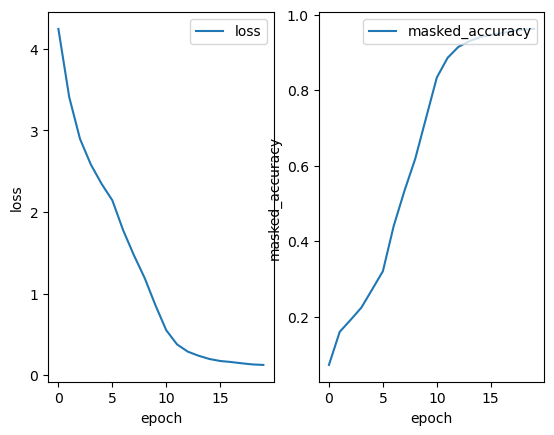

In [28]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [29]:
evaluate_seq2seq_model(seq2seq_episodic_abstracter);

per-card accuracy: 95.07%


## Multi-Abstracter Model

$$\text{Encoder} \to \text{Abstracter} \to \cdots \to \text{Abstracter} \to \text{Decoder}$$

In [30]:
from seq2seq_transformer import EpisodicDecoder

class Seq2seqEpisodicMultiAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim, n_abstracters=2,
            dropout_rate=0.1, name='seq2seq_episodic_multi_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracters = [
            EpisodicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
            for _ in range(n_abstracters)]
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = encoder_context
        for abstracter in self.abstracters:
            abstracted_context = abstracter(abstracted_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=abstracted_context, value_seq=abstracted_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [31]:
seq2seq_episodic_multiabstracter = Seq2seqEpisodicMultiAbstracter(num_layers=2, num_heads=2, dff=64,
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128, n_abstracters=2)

In [32]:
from seq2seq_transformer import masked_loss, masked_accuracy, CustomSchedule

learning_rate = CustomSchedule(d_model=128)
seq2seq_episodic_multiabstracter.compile(
    loss=masked_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=masked_accuracy)
seq2seq_episodic_multiabstracter((source_train, target_train))

seq2seq_episodic_multiabstracter.summary()

Model: "autoregressive_episodic_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (EpisodicDecoder  multiple                 563712    
 )                              

In [33]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive relational multi-abstracter')
history = seq2seq_episodic_multiabstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 31s 87ms/step - loss: 4.3324 - masked_accuracy: 0.0632
Epoch 2/20
118/118 [==============================] - 9s 79ms/step - loss: 3.4800 - masked_accuracy: 0.1555
Epoch 3/20
118/118 [==============================] - 9s 78ms/step - loss: 2.9167 - masked_accuracy: 0.1913
Epoch 4/20
118/118 [==============================] - 9s 78ms/step - loss: 2.6216 - masked_accuracy: 0.2145
Epoch 5/20
118/118 [==============================] - 9s 79ms/step - loss: 2.5034 - masked_accuracy: 0.2217
Epoch 6/20
118/118 [==============================] - 9s 80ms/step - loss: 2.4509 - masked_accuracy: 0.2270
Epoch 7/20
118/118 [==============================] - 9s 79ms/step - loss: 2.4172 - masked_accuracy: 0.2297
Epoch 8/20
118/118 [==============================] - 9s 78ms/step - loss: 2.4022 - masked_accuracy: 0.2333
Epoch 9/20
118/118 [==============================] - 9s 78ms/step - loss: 2.3485 - masked_accuracy: 0.2425
Epoch 10/20
118/118 [======

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▃▄▅▅▅▅▅▆▆▆▇▇▇▇█████
epoch/epoch,19
epoch/learning_rate,0.00082
epoch/loss,2.04895
epoch/masked_accuracy,0.32792


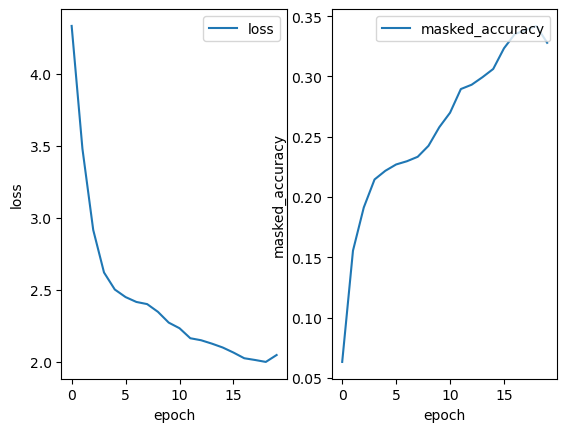

In [34]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [35]:
evaluate_seq2seq_model(seq2seq_episodic_multiabstracter);

per-card accuracy: 23.71%


## Unnamed Experimental Variant with Encoder-Decoder Skip Connection

- Encoder-Abstracter: Same as Episodic/Relational Abstracter above

- Decoder: Abstracter-Relations, Encoder-Values $(Q=A, K=A, V=E)$. I.e.: the sensory side (encoder and decoder) are connected via a skip connection

In [48]:
# changing source so that it is of the same length as the target and labels
# removing the last element from the source. the last element is always the end-of-sequence token anyways.
# i think this is fine

source_train = hands_train[:,:-1]
source_test = hands_test[:,:-1]

In [49]:
from seq2seq_transformer import EpisodicDecoder

class Seq2SeqSensoryConnectedAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='seq2seq_sensory_connected_abstracter'):
        super().__init__(name=name)

        self.token_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='vector_embedding')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = EpisodicDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        source, target  = inputs

        x = self.token_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.token_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=abstracted_context, key_seq=abstracted_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits

In [50]:
seq2seq_sensory_connected_abstracter = Seq2SeqSensoryConnectedAbstracter(num_layers=2, num_heads=2, dff=64,
    input_vocab_size=54, target_vocab_size=54, embedding_dim=128)

In [51]:
from seq2seq_transformer import masked_loss, masked_accuracy, CustomSchedule

learning_rate = CustomSchedule(d_model=128)
seq2seq_sensory_connected_abstracter.compile(
    loss=masked_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=masked_accuracy)
seq2seq_sensory_connected_abstracter((source_train, target_train))

seq2seq_sensory_connected_abstracter.summary()

Model: "autoregressive_episodic_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_embedding (Embedding  multiple                 6912      
 )                                                               
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  298112    
                                                                 
 abstracter (EpisodicDecoder  multiple                 563584    
 )                              

In [52]:
wandb.init(project='Autoregressive Abstracters (Card Sorting)', group='autoregressive sensory-connected abstracter')
history = seq2seq_sensory_connected_abstracter.fit((source_train, target_train), labels_train,
    epochs=20, batch_size=64, verbose=1, callbacks=create_callbacks())
wandb.finish()

Epoch 1/20
118/118 [==============================] - 23s 59ms/step - loss: 4.1854 - masked_accuracy: 0.0772
Epoch 2/20
118/118 [==============================] - 6s 53ms/step - loss: 3.2569 - masked_accuracy: 0.1723
Epoch 3/20
118/118 [==============================] - 6s 53ms/step - loss: 2.6276 - masked_accuracy: 0.2596
Epoch 4/20
118/118 [==============================] - 6s 53ms/step - loss: 1.6099 - masked_accuracy: 0.5707
Epoch 5/20
118/118 [==============================] - 6s 53ms/step - loss: 0.6051 - masked_accuracy: 0.8414
Epoch 6/20
118/118 [==============================] - 6s 53ms/step - loss: 0.3105 - masked_accuracy: 0.9176
Epoch 7/20
118/118 [==============================] - 6s 53ms/step - loss: 0.1911 - masked_accuracy: 0.9514
Epoch 8/20
118/118 [==============================] - 6s 53ms/step - loss: 0.1253 - masked_accuracy: 0.9683
Epoch 9/20
118/118 [==============================] - 6s 53ms/step - loss: 0.0928 - masked_accuracy: 0.9767
Epoch 10/20
118/118 [======

epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▆▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/masked_accuracy,▁▂▂▅▇▇██████████████
epoch/epoch,19
epoch/learning_rate,0.00082
epoch/loss,0.03138
epoch/masked_accuracy,0.99098


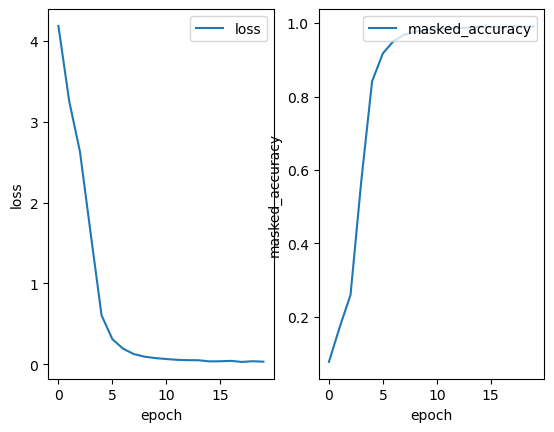

In [53]:
utils.plot_history(history, plot_attrs=['loss', 'masked_accuracy'], val=False);

In [54]:
evaluate_seq2seq_model(seq2seq_sensory_connected_abstracter);

per-card accuracy: 97.25%
